Mounting Google drive - Creates a directory /content/drive where the drive is accessible

In [19]:
 from google.colab import drive
 drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
import os

# Define the path you want to create
path = '/content/drive/MyDrive/Diabetic-Retinopathy-Detection/organized_dataset'

# Create the folders if they don't exist
os.makedirs(path, exist_ok=True)


In [22]:
import os

path = '/content/drive/MyDrive/Diabetic-Retinopathy-Detection/organized_dataset'
if os.path.exists(path):
    print("Path exists!")
else:
    print("Path does not exist:", path)


Path exists!


In [23]:

path = '/content/drive/MyDrive/Diabetic-Retinopathy-Detection'
print(os.listdir(path))


['organized_dataset', 'aptos2019-blindness-detection', 'preprocessed_data', 'Diabetic-Retinopathy-Detection.ipynb']


PRE-PROCESSING STEPS

In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path):
    # Load the image in BGR format
    image = cv2.imread(image_path)

    # Convert the image to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to 224x224
    image_resized = cv2.resize(image_rgb, (224, 224))

    # Apply CLAHE to each channel separately
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    channels = cv2.split(image_resized)
    clahe_channels = [clahe.apply(channel) for channel in channels]
    image_clahe = cv2.merge(clahe_channels)

    # Apply Gaussian Blur
    image_blur = cv2.GaussianBlur(image_clahe, (5, 5), 0)

    return image_blur

In [ ]:
def apply_function_to_dataset(input_dir, output_dir):
    for root, _, files in os.walk(input_dir):
        # Preserve the directory structure in the output directory
        relative_path = os.path.relpath(root, input_dir)
        target_dir = os.path.join(output_dir, relative_path)
        os.makedirs(target_dir, exist_ok=True)

        for file_name in files:
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check if the file is an image
                input_path = os.path.join(root, file_name)
                output_path = os.path.join(target_dir, file_name)

                # Apply the function and save the result
                processed_image = preprocess_image(input_path)
                cv2.imwrite(output_path, processed_image)
                print(f"Processed and saved: {output_path}")

In [ ]:
import os
import cv2
# Define the directory containing the dataset
input_dir = "/content/drive/MyDrive/Diabetic-Retinopathy-Detection/aptos2019-blindness-detection"
output_dir = "/content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data"

# Create the output directory
os.makedirs(output_dir, exist_ok=True)
# Apply the function to the dataset
apply_function_to_dataset(input_dir, output_dir)

Streaming output truncated to the last 5000 lines.
Processed and saved: /content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/train_images/e2a233493b90.png
Processed and saved: /content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/train_images/e2856afe62c5.png
Processed and saved: /content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/train_images/e2161692a0b4.png
Processed and saved: /content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/train_images/e251bdf05b85.png
Processed and saved: /content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/train_images/e26bcae6c67b.png
Processed and saved: /content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/train_images/e2265c383348.png
Processed and saved: /content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/train_images/e265c870f9b3.png
Processed and saved: /content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_

In [ ]:
import pandas as pd
import shutil

# Path to CSV and images
csv_path = '/content/drive/MyDrive/Diabetic-Retinopathy-Detection/aptos2019-blindness-detection/train.csv' # Adjust as needed
preprocessed_dir = '/content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/train_images'
organized_dir = '/content/drive/MyDrive/Diabetic-Retinopathy-Detection/organized_dataset'

# Read the CSV file
df = pd.read_csv(csv_path)

# Organize preprocessed images into class folders
for index, row in df.iterrows():
    image_id = row['id_code']  # Ensure this matches the CSV column name
    label = row['diagnosis']   # Ensure this matches the CSV column name

    src_path = os.path.join(preprocessed_dir, f'{image_id}.png')  # Adjust extension if needed
    dest_dir = os.path.join(organized_dir, str(label))
    os.makedirs(dest_dir, exist_ok=True)
    dest_path = os.path.join(dest_dir, f'{image_id}.png')

    shutil.move(src_path, dest_path)

TRAIN AND TEST

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
full_dataset = datasets.ImageFolder('/content/drive/MyDrive/Diabetic-Retinopathy-Detection/organized_dataset', transform=train_transform)

Class Distribution

Class Distribution: Counter({0: 1805, 2: 999, 1: 370, 4: 295, 3: 193})


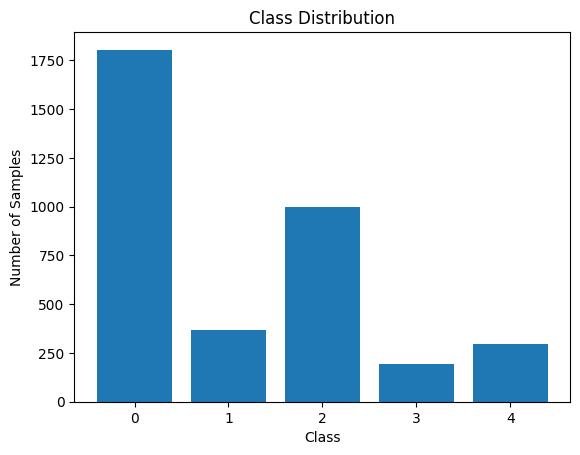

In [25]:
import matplotlib.pyplot as plt
from collections import Counter

# Directly access targets
class_counts = Counter(full_dataset.targets)

# Class distribution
print("Class Distribution:", class_counts)

# Plotting class distribution
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy trends
def plot_training_results(epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots training and validation loss and accuracy trends.
    """

    print("Training and Validation Loss Trends:")
    print(f"Train Losses: {train_losses}")
    print(f"Validation Losses: {val_losses}")

    print("\nTraining and Validation Accuracy Trends:")
    print(f"Train Accuracies: {train_accuracies}")
    print(f"Validation Accuracies: {val_accuracies}")
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Trends")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy")
    plt.plot(range(1, epochs + 1), val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Trends")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [29]:
# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    """
    Trains the model and calculates metrics for each epoch.
    """
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = train_correct / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = val_loss / total_val
        epoch_val_acc = val_correct / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {epoch_train_acc:.4f}")
        print(f"  Val Loss:   {epoch_val_loss:.4f} | Val Accuracy:   {epoch_val_acc:.4f}")

    # Call the plot function after training is complete
    plot_training_results(epochs, train_losses, val_losses, train_accuracies, val_accuracies)


In [31]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

# Evaluate the model
def evaluate_model(model, data_loader, device, num_classes):
    """
    Evaluates the model and returns metrics like confusion matrix, sensitivity, specificity, and ROC-AUC.
    """
    model.eval()
    y_true = []  # Ground truth labels
    y_pred = []  # Predicted labels
    y_probs = []  # Predicted probabilities for ROC-AUC

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_probs = np.array(y_probs)

    # Metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_probs, multi_class="ovr") if num_classes > 2 else roc_auc_score(y_true, y_probs[:, 1])

    # Print metrics
    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[f"Class {i}" for i in range(num_classes)]))
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return cm, accuracy, recall, precision, f1, roc_auc

In [32]:
def prepare_loaders(dataset, train_idx, val_idx, batch_size=32):
    """
    Prepares training and validation DataLoaders for the given indices.
    """
    train_sub = Subset(dataset, train_idx)
    val_sub = Subset(dataset, val_idx)
    train_loader = DataLoader(train_sub, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_sub, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def kfold_train(model, dataset, k_folds=4, epochs=10):
    """
    Performs K-Fold Cross-Validation and aggregates results.
    """
    kfold = KFold(n_splits=k_folds, shuffle=True)
    aggregated_results = {
        "accuracy": [],
        "recall": [],
        "precision": [],
        "f1_score": [],
        "roc_auc": []
    }
    confusion_matrices = []

    # Calculate class weights for the dataset
    class_counts = np.bincount([label for _, label in dataset.samples])
    class_weights = 1.0 / class_counts
    class_weights = torch.tensor(class_weights).float().to(device)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold+1}")
        train_loader, val_loader = prepare_loaders(dataset, train_idx, val_idx)

        # Initialize a fresh model
        model_copy = models.resnet18(pretrained=True)
        model_copy.fc = nn.Linear(model_copy.fc.in_features, len(dataset.classes))
        model_copy = model_copy.to(device)

        optimizer = torch.optim.Adam(model_copy.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss(weight=class_weights)

        # Train the model
        train_model(model_copy, train_loader, val_loader, criterion, optimizer, epochs)

        # Evaluate the model
        print(f"\nEvaluation Metrics for Fold {fold+1}")
        cm, accuracy, recall, precision, f1, roc_auc = evaluate_model(
            model_copy, val_loader, device, num_classes=len(dataset.classes)
        )

        # Store results
        aggregated_results["accuracy"].append(accuracy)
        aggregated_results["recall"].append(recall)
        aggregated_results["precision"].append(precision)
        aggregated_results["f1_score"].append(f1)
        aggregated_results["roc_auc"].append(roc_auc)
        confusion_matrices.append(cm)

    # Aggregate results
    avg_results = {metric: np.mean(values) for metric, values in aggregated_results.items()}
    std_results = {metric: np.std(values) for metric, values in aggregated_results.items()}
    total_cm = np.sum(confusion_matrices, axis=0)

    print("\nAggregated Metrics:")
    for metric, value in avg_results.items():
        print(f"{metric.capitalize()} (mean ± std): {value:.4f} ± {std_results[metric]:.4f}")

    print("\nTotal Confusion Matrix:")
    print(total_cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(total_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Aggregated Confusion Matrix")
    plt.show()

    return avg_results, total_cm


In [41]:
import random
from PIL import Image
# Grad-CAM for random images from each class
def generate_grad_cam_images(model, dataset, device, transform, target_layer):
    """
    Visualize Grad-CAM for one random image from each class.
    """
    grad_cam = GradCAM(model, target_layer)
    class_images = {cls: [] for cls in range(len(dataset.classes))}

    # Collect images for each class
    for path, label in dataset.samples:
        class_images[label].append(path)

    # Generate Grad-CAM for one random image per class
    for cls, images in class_images.items():
        random_image_path = random.choice(images)
        image = Image.open(random_image_path)
        input_tensor = transform(image).unsqueeze(0).to(device)

        model.eval()
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)

        outputs[:, preds.item()].backward()
        heatmap = grad_cam.generate_heatmap(preds.item())
        overlay = visualize_grad_cam(input_tensor.squeeze(0), heatmap)

        plt.imshow(overlay)
        plt.title(f"Class: {cls}, Predicted: {preds.item()}")
        plt.axis("off")
        plt.show()


In [49]:
import os
import cv2
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
# Predict test data
def predict_test_data(model, test_csv, test_folder, transform, device):
    """
    Predict the classes for the test dataset.
    """
    test_data = pd.read_csv(test_csv)
    predictions = []

    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        image_path = os.path.join(test_folder, f"{row['id_code']}.png")
        image = Image.open(image_path)
        input_tensor = transform(image).unsqueeze(0).to(device)

        model.eval()
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)

        predictions.append(preds.item())

    test_data['diagnosis'] = predictions
    test_data.to_csv("test_predictions.csv", index=False)
    print("Predictions saved to test_predictions.csv.")

In [36]:
# Initialize and run k-fold training
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(full_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1


Training Epoch 1/10: 100%|██████████| 86/86 [23:14<00:00, 16.21s/it]


Epoch 1/10
  Train Loss: 1.2368 | Train Accuracy: 0.6227
  Val Loss:   0.7994 | Val Accuracy:   0.6692


Training Epoch 2/10: 100%|██████████| 86/86 [13:56<00:00,  9.73s/it]


Epoch 2/10
  Train Loss: 1.0122 | Train Accuracy: 0.6945
  Val Loss:   0.8466 | Val Accuracy:   0.6332


Training Epoch 3/10: 100%|██████████| 86/86 [14:04<00:00,  9.82s/it]


Epoch 3/10
  Train Loss: 0.9255 | Train Accuracy: 0.7261
  Val Loss:   0.6604 | Val Accuracy:   0.7489


Training Epoch 4/10: 100%|██████████| 86/86 [13:54<00:00,  9.70s/it]


Epoch 4/10
  Train Loss: 0.8794 | Train Accuracy: 0.7436
  Val Loss:   0.5831 | Val Accuracy:   0.7915


Training Epoch 5/10: 100%|██████████| 86/86 [13:53<00:00,  9.69s/it]


Epoch 5/10
  Train Loss: 0.8559 | Train Accuracy: 0.7451
  Val Loss:   0.8915 | Val Accuracy:   0.6550


Training Epoch 6/10: 100%|██████████| 86/86 [13:48<00:00,  9.64s/it]


Epoch 6/10
  Train Loss: 0.7885 | Train Accuracy: 0.7739
  Val Loss:   0.8786 | Val Accuracy:   0.6408


Training Epoch 7/10: 100%|██████████| 86/86 [13:39<00:00,  9.53s/it]


Epoch 7/10
  Train Loss: 0.7910 | Train Accuracy: 0.7749
  Val Loss:   0.9229 | Val Accuracy:   0.6266


Training Epoch 8/10: 100%|██████████| 86/86 [13:47<00:00,  9.62s/it]


Epoch 8/10
  Train Loss: 0.7876 | Train Accuracy: 0.7709
  Val Loss:   0.5752 | Val Accuracy:   0.7718


Training Epoch 9/10: 100%|██████████| 86/86 [13:35<00:00,  9.48s/it]


Epoch 9/10
  Train Loss: 0.7535 | Train Accuracy: 0.7790
  Val Loss:   0.9335 | Val Accuracy:   0.6932


Training Epoch 10/10: 100%|██████████| 86/86 [13:39<00:00,  9.53s/it]


Epoch 10/10
  Train Loss: 0.7324 | Train Accuracy: 0.7866
  Val Loss:   0.5611 | Val Accuracy:   0.7762
Training and Validation Loss Trends:
Train Losses: [1.2368383251743775, 1.0122386870033449, 0.9254769545268249, 0.8793798597381659, 0.8558642364555437, 0.7885362169904077, 0.7910326604242318, 0.7876158581974727, 0.7535194078676039, 0.7324424271850974]
Validation Losses: [0.7994283929662412, 0.8466270433242664, 0.6604194971671792, 0.5830775611915964, 0.8914682044277545, 0.8785581505454784, 0.922933565997661, 0.575154473281193, 0.9334569449808985, 0.5610912969929682]

Training and Validation Accuracy Trends:
Train Accuracies: [0.6227239621267298, 0.6944646758922068, 0.7261471230881282, 0.7436270939548434, 0.7450837581937363, 0.7738528769118718, 0.7749453750910416, 0.770939548434086, 0.778951201747997, 0.786598689002185]
Validation Accuracies: [0.6692139737991266, 0.6331877729257642, 0.7489082969432315, 0.7914847161572053, 0.6550218340611353, 0.6408296943231441, 0.6266375545851528, 0.77

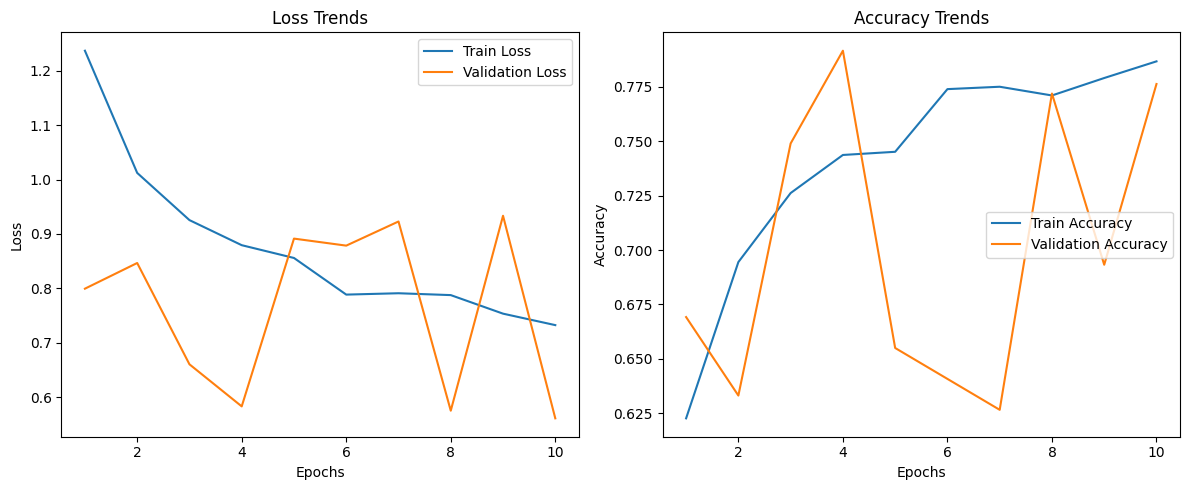


Evaluation Metrics for Fold 1

Confusion Matrix:
[[429  10   1   0   0]
 [  8  79  20   3   2]
 [ 10  34 142  21  38]
 [  0   1  10  31  15]
 [  0   3  14   8  37]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.96      0.97      0.97       440
     Class 1       0.62      0.71      0.66       112
     Class 2       0.76      0.58      0.66       245
     Class 3       0.49      0.54      0.52        57
     Class 4       0.40      0.60      0.48        62

    accuracy                           0.78       916
   macro avg       0.65      0.68      0.66       916
weighted avg       0.80      0.78      0.79       916


Accuracy: 0.7838
Precision: 0.6471
Recall: 0.6801
F1-Score: 0.6566
ROC-AUC: 0.9431
Fold 2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1/10: 100%|██████████| 86/86 [14:01<00:00,  9.78s/it]


Epoch 1/10
  Train Loss: 1.2312 | Train Accuracy: 0.5932
  Val Loss:   0.6882 | Val Accuracy:   0.7009


Training Epoch 2/10: 100%|██████████| 86/86 [14:10<00:00,  9.89s/it]


Epoch 2/10
  Train Loss: 0.9994 | Train Accuracy: 0.6595
  Val Loss:   0.8869 | Val Accuracy:   0.6343


Training Epoch 3/10: 100%|██████████| 86/86 [14:01<00:00,  9.78s/it]


Epoch 3/10
  Train Loss: 0.9431 | Train Accuracy: 0.7050
  Val Loss:   0.6751 | Val Accuracy:   0.7063


Training Epoch 4/10: 100%|██████████| 86/86 [14:12<00:00,  9.91s/it]


Epoch 4/10
  Train Loss: 0.8787 | Train Accuracy: 0.7305
  Val Loss:   0.5910 | Val Accuracy:   0.7555


Training Epoch 5/10: 100%|██████████| 86/86 [14:01<00:00,  9.79s/it]


Epoch 5/10
  Train Loss: 0.8436 | Train Accuracy: 0.7323
  Val Loss:   0.6309 | Val Accuracy:   0.7358


Training Epoch 6/10: 100%|██████████| 86/86 [14:15<00:00,  9.95s/it]


Epoch 6/10
  Train Loss: 0.8303 | Train Accuracy: 0.7454
  Val Loss:   0.5937 | Val Accuracy:   0.7358


Training Epoch 7/10: 100%|██████████| 86/86 [14:00<00:00,  9.77s/it]


Epoch 7/10
  Train Loss: 0.7539 | Train Accuracy: 0.7717
  Val Loss:   0.6957 | Val Accuracy:   0.7140


Training Epoch 8/10: 100%|██████████| 86/86 [13:58<00:00,  9.75s/it]


Epoch 8/10
  Train Loss: 0.7338 | Train Accuracy: 0.7779
  Val Loss:   0.7283 | Val Accuracy:   0.7107


Training Epoch 9/10: 100%|██████████| 86/86 [14:00<00:00,  9.77s/it]


Epoch 9/10
  Train Loss: 0.7277 | Train Accuracy: 0.7797
  Val Loss:   0.5817 | Val Accuracy:   0.7620


Training Epoch 10/10: 100%|██████████| 86/86 [14:00<00:00,  9.78s/it]


Epoch 10/10
  Train Loss: 0.6799 | Train Accuracy: 0.7939
  Val Loss:   0.5812 | Val Accuracy:   0.7849
Training and Validation Loss Trends:
Train Losses: [1.2311609739034781, 0.999436529205389, 0.9430547473817869, 0.8787260915099142, 0.8435946923489998, 0.8303263414453088, 0.7538984876345824, 0.7338453193520076, 0.7276776316863989, 0.67988323106092]
Validation Losses: [0.68815525364147, 0.8869106415577851, 0.6751352336469175, 0.5910219011999114, 0.6309163189090495, 0.593699253477384, 0.6957348694447346, 0.728323180082063, 0.5817219680053178, 0.5811839585871675]

Training and Validation Accuracy Trends:
Train Accuracies: [0.5932265112891478, 0.6595047341587764, 0.7050254916241806, 0.7305171158048069, 0.7323379461034232, 0.7454479242534596, 0.7716678805535324, 0.7778587035688274, 0.7796795338674436, 0.7938820101966497]
Validation Accuracies: [0.7008733624454149, 0.6342794759825328, 0.7063318777292577, 0.7554585152838428, 0.7358078602620087, 0.7358078602620087, 0.7139737991266376, 0.7106

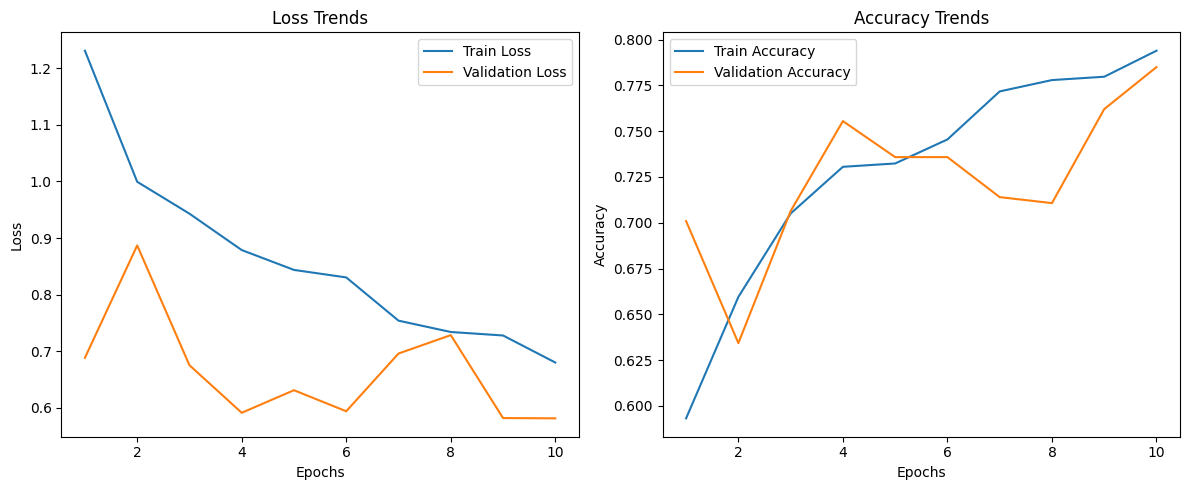


Evaluation Metrics for Fold 2

Confusion Matrix:
[[462  13   3   0   0]
 [  4  56   5   0   3]
 [  3  66 141  15  26]
 [  0   5  20   6  11]
 [  0  10  22   5  40]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.99      0.97      0.98       478
     Class 1       0.37      0.82      0.51        68
     Class 2       0.74      0.56      0.64       251
     Class 3       0.23      0.14      0.18        42
     Class 4       0.50      0.52      0.51        77

    accuracy                           0.77       916
   macro avg       0.57      0.60      0.56       916
weighted avg       0.80      0.77      0.77       916


Accuracy: 0.7697
Precision: 0.5655
Recall: 0.6028
F1-Score: 0.5627
ROC-AUC: 0.9318
Fold 3


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1/10: 100%|██████████| 86/86 [14:01<00:00,  9.79s/it]


Epoch 1/10
  Train Loss: 1.2824 | Train Accuracy: 0.5832
  Val Loss:   1.4794 | Val Accuracy:   0.2284


Training Epoch 2/10: 100%|██████████| 86/86 [13:55<00:00,  9.71s/it]


Epoch 2/10
  Train Loss: 0.9932 | Train Accuracy: 0.6949
  Val Loss:   0.6876 | Val Accuracy:   0.7497


Training Epoch 3/10: 100%|██████████| 86/86 [13:59<00:00,  9.77s/it]


Epoch 3/10
  Train Loss: 0.9136 | Train Accuracy: 0.7150
  Val Loss:   0.9620 | Val Accuracy:   0.5956


Training Epoch 4/10: 100%|██████████| 86/86 [14:03<00:00,  9.81s/it]


Epoch 4/10
  Train Loss: 0.8924 | Train Accuracy: 0.7252
  Val Loss:   0.8709 | Val Accuracy:   0.6492


Training Epoch 5/10: 100%|██████████| 86/86 [13:57<00:00,  9.74s/it]


Epoch 5/10
  Train Loss: 0.8531 | Train Accuracy: 0.7506
  Val Loss:   0.8322 | Val Accuracy:   0.7301


Training Epoch 6/10: 100%|██████████| 86/86 [13:58<00:00,  9.75s/it]


Epoch 6/10
  Train Loss: 0.8049 | Train Accuracy: 0.7510
  Val Loss:   0.9602 | Val Accuracy:   0.6306


Training Epoch 7/10: 100%|██████████| 86/86 [13:48<00:00,  9.63s/it]


Epoch 7/10
  Train Loss: 0.7916 | Train Accuracy: 0.7601
  Val Loss:   0.6085 | Val Accuracy:   0.7617


Training Epoch 8/10: 100%|██████████| 86/86 [14:00<00:00,  9.78s/it]


Epoch 8/10
  Train Loss: 0.7347 | Train Accuracy: 0.7849
  Val Loss:   1.2160 | Val Accuracy:   0.5760


Training Epoch 9/10: 100%|██████████| 86/86 [14:01<00:00,  9.79s/it]


Epoch 9/10
  Train Loss: 0.7069 | Train Accuracy: 0.7830
  Val Loss:   0.5504 | Val Accuracy:   0.8098


Training Epoch 10/10: 100%|██████████| 86/86 [13:56<00:00,  9.73s/it]


Epoch 10/10
  Train Loss: 0.6734 | Train Accuracy: 0.7881
  Val Loss:   0.6631 | Val Accuracy:   0.7563
Training and Validation Loss Trends:
Train Losses: [1.2823838073425307, 0.9931967601283143, 0.9135570076538686, 0.8923519787286731, 0.8531478477643974, 0.8049083757300701, 0.7915648124762175, 0.7347122391744835, 0.7068825230886601, 0.6734431824729276]
Validation Losses: [1.4794381559872236, 0.6875629327336296, 0.9620205570439824, 0.8709328364153377, 0.8321870129535107, 0.9602232476075491, 0.608467060099534, 1.2160201566629723, 0.5503989043131552, 0.6630926624021894]

Training and Validation Accuracy Trends:
Train Accuracies: [0.5831816527120495, 0.6949399344739716, 0.7149617764834365, 0.7251547142337095, 0.7506370586093921, 0.7510010921004733, 0.7601019293775028, 0.784856206771023, 0.783036039315617, 0.7881325081907535]
Validation Accuracies: [0.2284153005464481, 0.7497267759562841, 0.5956284153005464, 0.6491803278688525, 0.7300546448087432, 0.6306010928961748, 0.7617486338797814, 0.

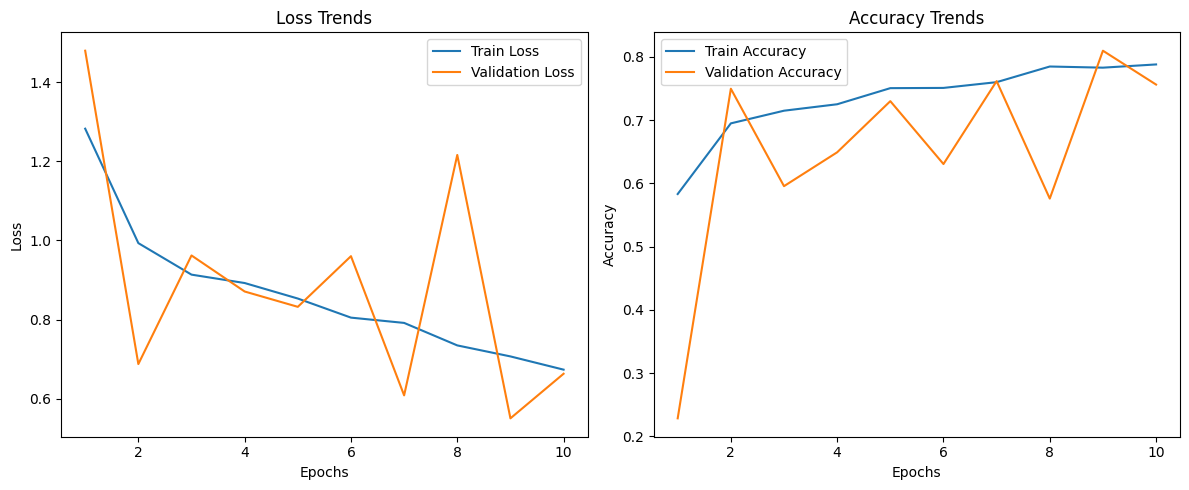


Evaluation Metrics for Fold 3

Confusion Matrix:
[[408  14   3   8   2]
 [  7  68   8   6   1]
 [  7  58 141  41  11]
 [  0   3  14  27  12]
 [  0   6  16  17  37]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.94      0.95       435
     Class 1       0.46      0.76      0.57        90
     Class 2       0.77      0.55      0.64       258
     Class 3       0.27      0.48      0.35        56
     Class 4       0.59      0.49      0.53        76

    accuracy                           0.74       915
   macro avg       0.61      0.64      0.61       915
weighted avg       0.79      0.74      0.75       915


Accuracy: 0.7443
Precision: 0.6116
Recall: 0.6418
F1-Score: 0.6086
ROC-AUC: 0.9251
Fold 4


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1/10: 100%|██████████| 86/86 [13:44<00:00,  9.59s/it]


Epoch 1/10
  Train Loss: 1.1904 | Train Accuracy: 0.6152
  Val Loss:   0.8755 | Val Accuracy:   0.6623


Training Epoch 2/10: 100%|██████████| 86/86 [13:54<00:00,  9.70s/it]


Epoch 2/10
  Train Loss: 0.9783 | Train Accuracy: 0.6793
  Val Loss:   0.9479 | Val Accuracy:   0.6525


Training Epoch 3/10: 100%|██████████| 86/86 [13:51<00:00,  9.67s/it]


Epoch 3/10
  Train Loss: 0.8818 | Train Accuracy: 0.7135
  Val Loss:   0.7119 | Val Accuracy:   0.7224


Training Epoch 4/10: 100%|██████████| 86/86 [13:48<00:00,  9.63s/it]


Epoch 4/10
  Train Loss: 0.8789 | Train Accuracy: 0.7328
  Val Loss:   0.7169 | Val Accuracy:   0.7290


Training Epoch 5/10: 100%|██████████| 86/86 [13:48<00:00,  9.63s/it]


Epoch 5/10
  Train Loss: 0.8061 | Train Accuracy: 0.7630
  Val Loss:   0.8132 | Val Accuracy:   0.7005


Training Epoch 6/10: 100%|██████████| 86/86 [13:41<00:00,  9.55s/it]


Epoch 6/10
  Train Loss: 0.8459 | Train Accuracy: 0.7466
  Val Loss:   0.5927 | Val Accuracy:   0.7650


Training Epoch 7/10: 100%|██████████| 86/86 [13:28<00:00,  9.40s/it]


Epoch 7/10
  Train Loss: 0.7306 | Train Accuracy: 0.7772
  Val Loss:   0.8878 | Val Accuracy:   0.7104


Training Epoch 8/10: 100%|██████████| 86/86 [13:46<00:00,  9.61s/it]


Epoch 8/10
  Train Loss: 0.7023 | Train Accuracy: 0.7881
  Val Loss:   0.6361 | Val Accuracy:   0.7596


Training Epoch 9/10: 100%|██████████| 86/86 [13:48<00:00,  9.63s/it]


Epoch 9/10
  Train Loss: 0.7132 | Train Accuracy: 0.7801
  Val Loss:   1.2378 | Val Accuracy:   0.5399


Training Epoch 10/10: 100%|██████████| 86/86 [13:36<00:00,  9.50s/it]


Epoch 10/10
  Train Loss: 0.7190 | Train Accuracy: 0.7859
  Val Loss:   0.6545 | Val Accuracy:   0.7290
Training and Validation Loss Trends:
Train Losses: [1.1904173288772355, 0.9783164442865728, 0.8818012867183914, 0.878891672574263, 0.8061420259624991, 0.8459445568792248, 0.7305736597946092, 0.702261594900184, 0.7132109971883126, 0.7189549866007335]
Validation Losses: [0.8754774924835872, 0.9479055639173164, 0.7118743380562204, 0.7168521716946461, 0.8131562481812441, 0.5926871540767898, 0.8877615731229873, 0.6361398088557473, 1.2377625675800719, 0.6544528975512812]

Training and Validation Accuracy Trends:
Train Accuracies: [0.6152165999271934, 0.6792864943574809, 0.7135056425191117, 0.7327994175464143, 0.7630141973061522, 0.7466326902074991, 0.7772115034583181, 0.7881325081907535, 0.7801237713869676, 0.7859483072442665]
Validation Accuracies: [0.6622950819672131, 0.6524590163934426, 0.7224043715846995, 0.7289617486338797, 0.7005464480874317, 0.7650273224043715, 0.7103825136612022, 0

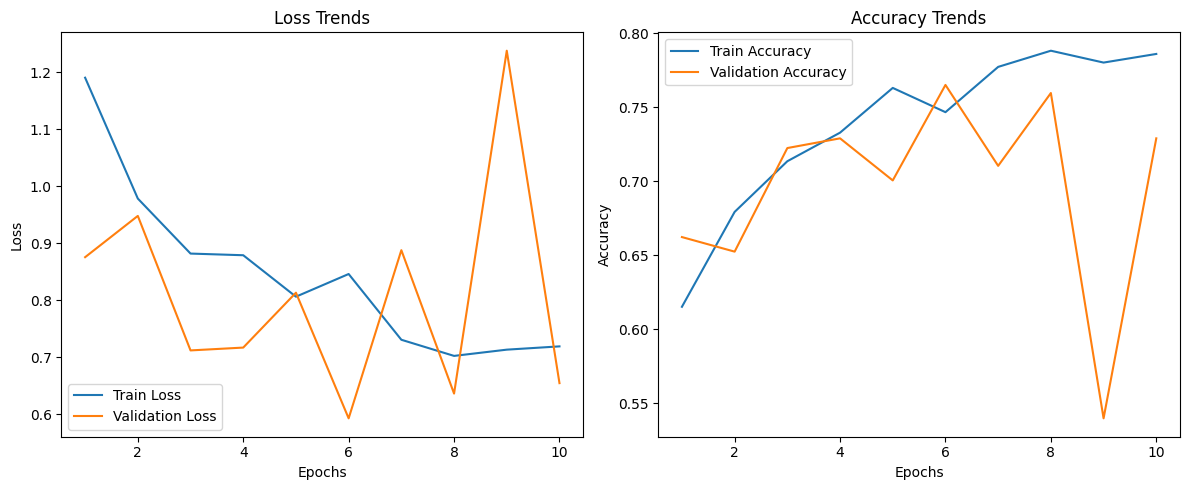


Evaluation Metrics for Fold 4

Confusion Matrix:
[[417  33   1   1   0]
 [  5  52  35   3   5]
 [  5  32 145  47  16]
 [  0   0   9  25   4]
 [  0  10  15  19  36]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.98      0.92      0.95       452
     Class 1       0.41      0.52      0.46       100
     Class 2       0.71      0.59      0.64       245
     Class 3       0.26      0.66      0.38        38
     Class 4       0.59      0.45      0.51        80

    accuracy                           0.74       915
   macro avg       0.59      0.63      0.59       915
weighted avg       0.78      0.74      0.75       915


Accuracy: 0.7377
Precision: 0.5893
Recall: 0.6285
F1-Score: 0.5876
ROC-AUC: 0.9145

Aggregated Metrics:
Accuracy (mean ± std): 0.7589 ± 0.0187
Recall (mean ± std): 0.6383 ± 0.0279
Precision (mean ± std): 0.6034 ± 0.0300
F1_score (mean ± std): 0.6039 ± 0.0345
Roc_auc (mean ± std): 0.9286 ± 0.0104

Total Confusion Matrix

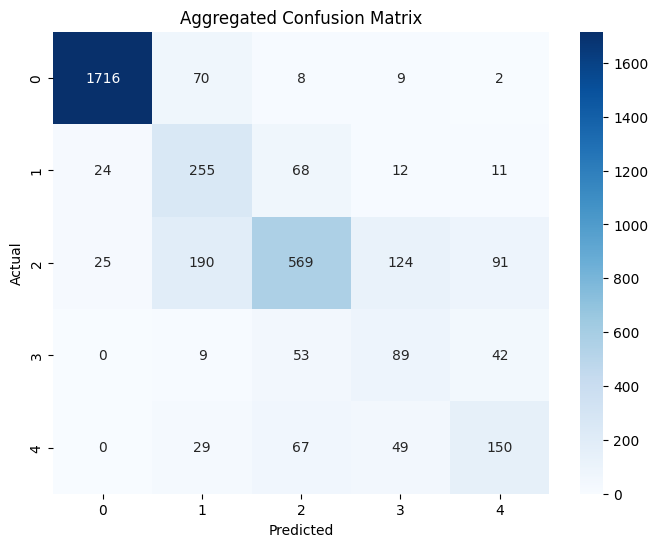

In [37]:
results, total_cm = kfold_train(model, full_dataset, k_folds=4, epochs=10)

In [51]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Use the regular hooks to avoid conflicts
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        """
        Forward hook to capture activations.
        """
        self.activations = output

    def backward_hook(self, module, grad_input, grad_output):
        """
        Backward hook to capture gradients.
        """
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        """
        Generate Grad-CAM heatmap for the given class index.
        """
        # Compute weights
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)

        # Clamp and normalize
        cam = torch.clamp(cam, min=0).squeeze().detach().cpu().numpy()
        cam -= cam.min()
        cam /= cam.max()
        return cam


In [54]:
import numpy as np

def visualize_grad_cam(image, heatmap, alpha=0.6):
    """
    Visualizes Grad-CAM overlay on the input image.
    """
    # Convert image tensor to numpy and ensure it's in the correct format
    image_np = image.permute(1, 2, 0).cpu().numpy()

    # Convert from [0, 1] range to [0, 255]
    image_np = np.clip(image_np * 255.0, 0, 255).astype(np.uint8)

    # Resize heatmap to match the input image dimensions
    heatmap = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend the heatmap with the original image
    overlay = cv2.addWeighted(image_np, 1 - alpha, heatmap, alpha, 0)

    return overlay


In [60]:
def generate_grad_cam_images(model, dataset, device, transform, target_layer):
    """
    Visualize Grad-CAM for one random image from each class, along with original and heatmap images.
    """
    grad_cam = GradCAM(model, target_layer)
    class_images = {cls: [] for cls in range(len(dataset.classes))}

    # Collect images for each class
    for path, label in dataset.samples:
        class_images[label].append(path)

    # Generate Grad-CAM for one random image per class
    for cls, images in class_images.items():
        random_image_path = random.choice(images)
        image = Image.open(random_image_path).convert('RGB')
        input_tensor = transform(image).unsqueeze(0).to(device)

        # Set the model to evaluation mode
        model.eval()

        # Forward pass to get predictions
        outputs = model(input_tensor)
        _, preds = torch.max(outputs, 1)

        # Backpropagate to the predicted class
        model.zero_grad()  # Zero-out previous gradients to avoid accumulation
        outputs[:, preds.item()].backward()

        # Generate heatmap
        heatmap = grad_cam.generate_heatmap(preds.item())

        # Convert the image tensor to numpy for visualization
        image_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
        image_np = np.clip(image_np * 255.0, 0, 255).astype(np.uint8)

        # Visualize Grad-CAM overlay
        overlay = visualize_grad_cam(input_tensor.squeeze(0), heatmap)

        # Resize the heatmap for visualization purposes
        heatmap_resized = cv2.resize(heatmap, (image_np.shape[1], image_np.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        # Plot original image, heatmap, and Grad-CAM overlay side-by-side
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(image_np)
        plt.title(f"Original Image (Class: {cls}, Predicted: {preds.item()})")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap_colored)
        plt.title("Grad-CAM Heatmap")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Grad-CAM Overlay")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


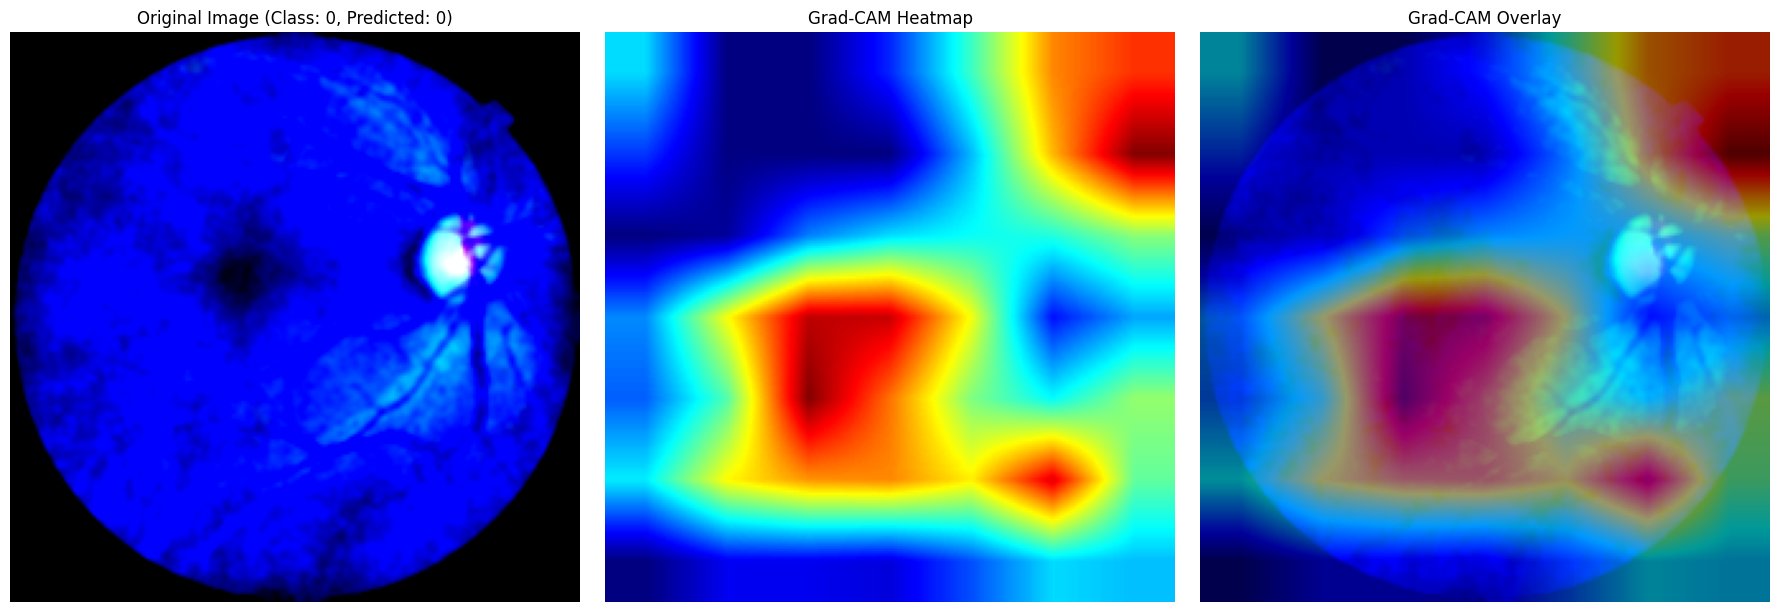

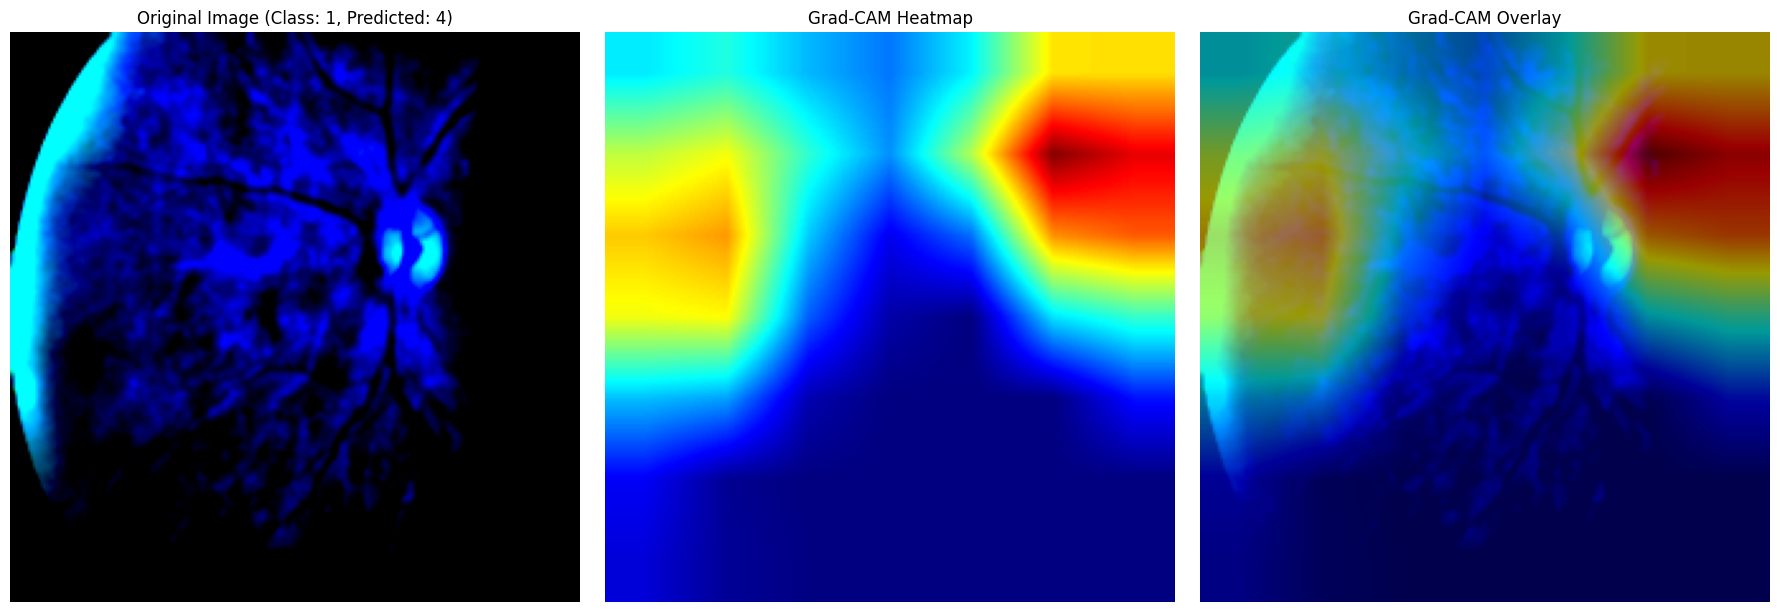

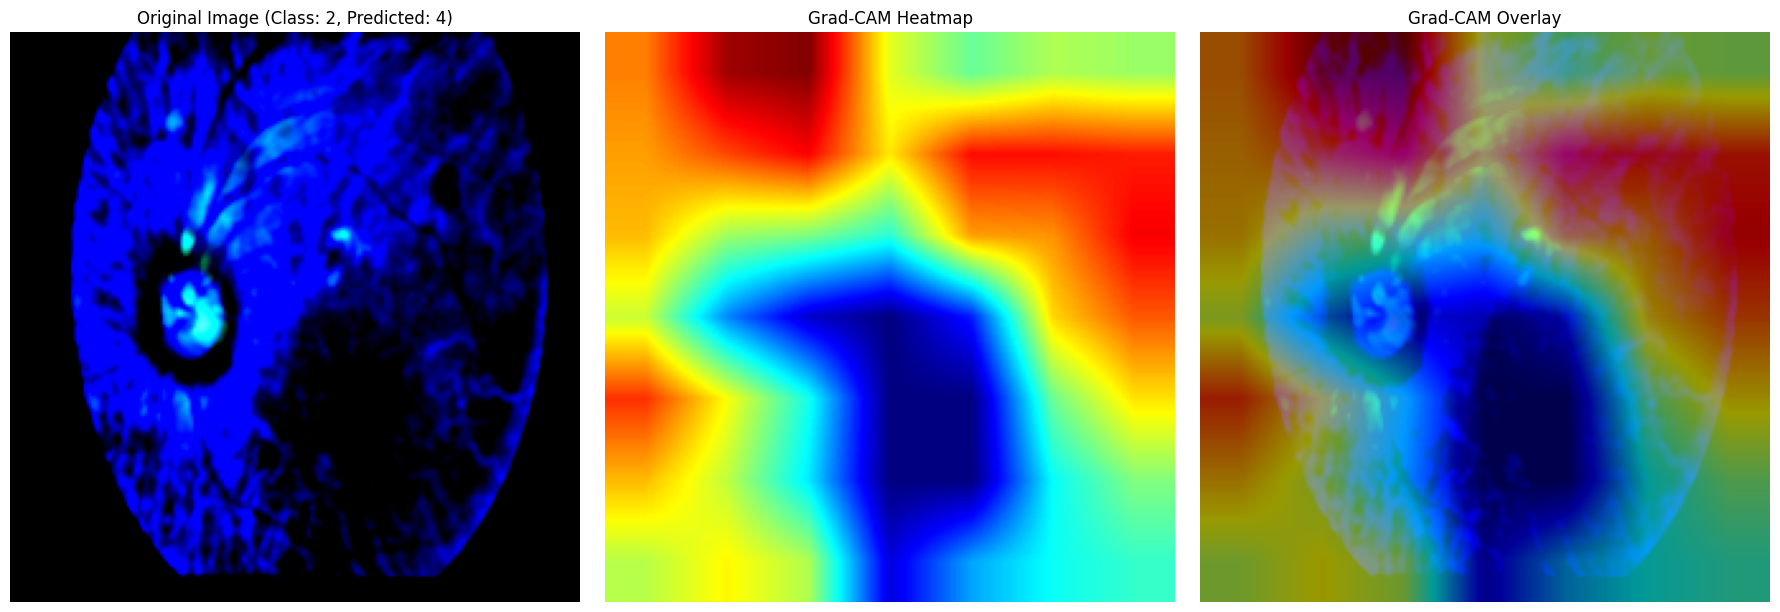

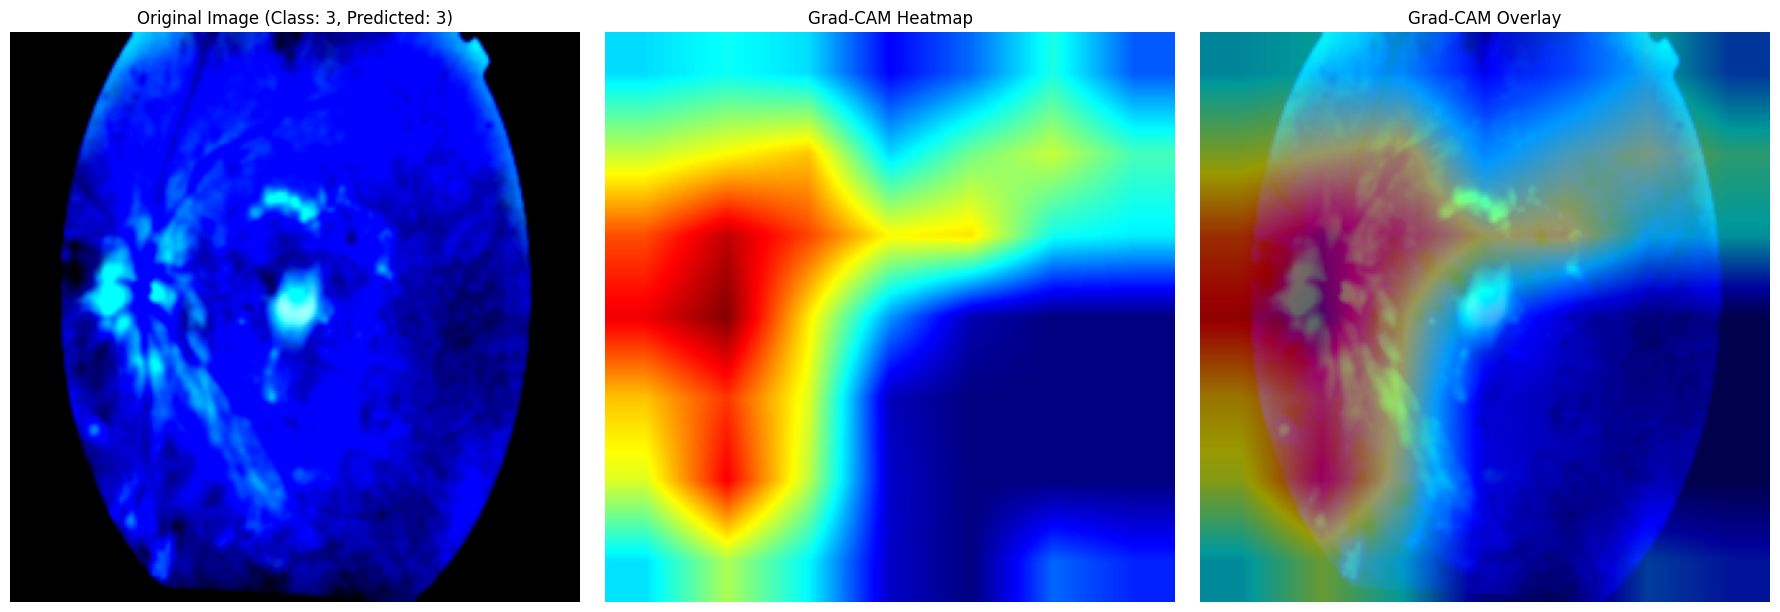

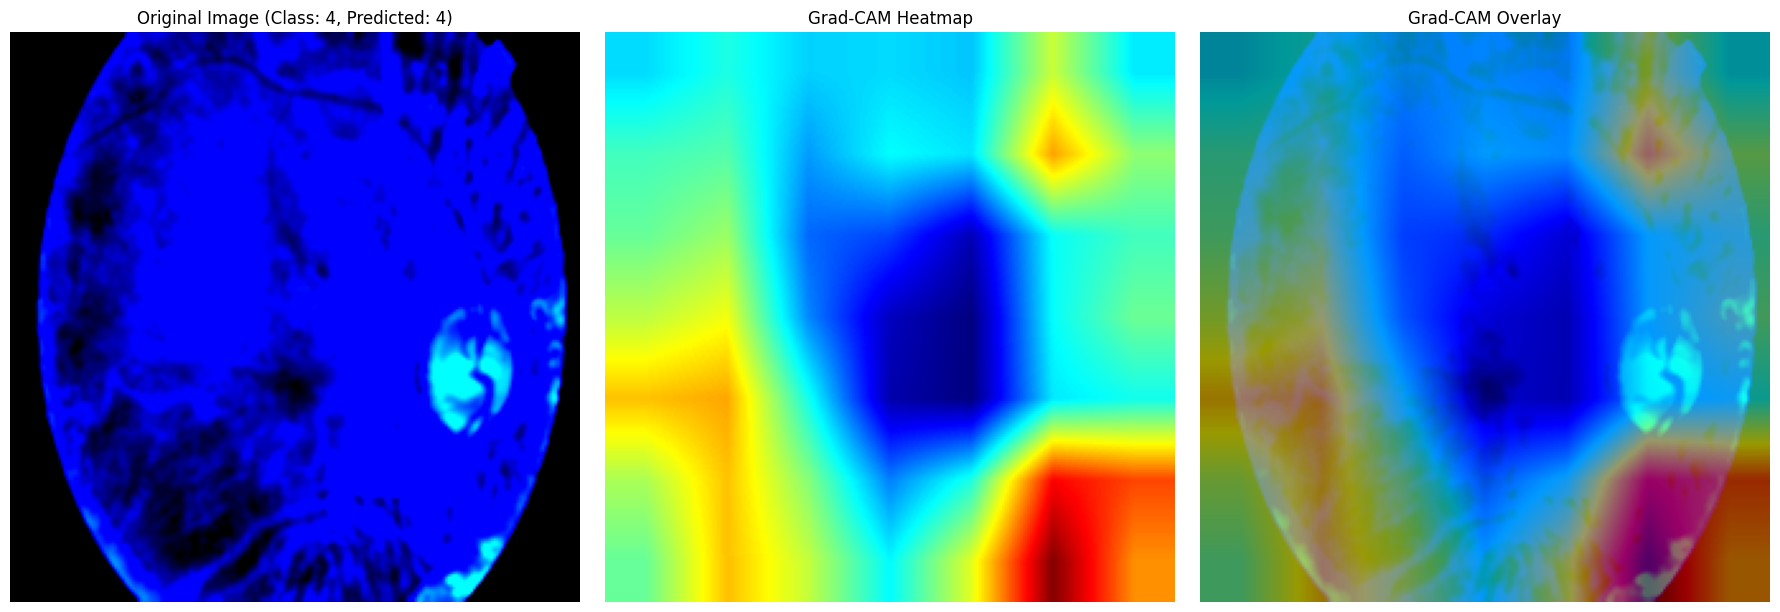

In [63]:
generate_grad_cam_images(model, full_dataset, device, val_transform, target_layer=model.layer4[-1])

In [50]:
# Test data prediction
test_csv = "/content/drive/MyDrive/Diabetic-Retinopathy-Detection/aptos2019-blindness-detection/test.csv"
test_folder = "/content/drive/MyDrive/Diabetic-Retinopathy-Detection/preprocessed_data/test_images"
predict_test_data(model, test_csv, test_folder, val_transform, device)

  0%|          | 0/1928 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 1928/1928 [12:33<00:00,  2.56it/s]

Predictions saved to test_predictions.csv.
